# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS1090A Introduction to Data Science 

# Section 11: Bagging & Random Forests

**Harvard University**<br/>
**Fall 2025**<br/>
**Instructors**: Pavlos Protopapas and Kevin Rader<br/>
<hr style='height:2px'>

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn import tree

from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

In [3]:
# Supress pesky warnings (probably bad practice)
from warnings import simplefilter

simplefilter(action="ignore")

In [ ]:
import os
import subprocess

# Define the name of the zip file containing your assets
assets_zip_name = "notebook_assets.zip"

# Define the directories that should be present after extraction
expected_dirs = ["data", "fig"]

# Construct the raw GitHub URL for the zip file
github_raw_url = f"https://github.com/Harvard-CS1090A/2025-public/raw/main/sec11/{assets_zip_name}"

# Check if running in Google Colab
if 'COLAB_GPU' in os.environ:
    print("Running in Google Colab. Checking for necessary files...")

    # Check if the expected directories already exist
    all_dirs_exist = True
    for d in expected_dirs:
        if not os.path.isdir(d):
            all_dirs_exist = False
            break

    if all_dirs_exist:
        print("Required directories already exist. Skipping download.")
    else:
        print(f"Required directories not found. Downloading {assets_zip_name} from GitHub...")

        try:
            # Download the zip file
            subprocess.run(['wget', '-q', github_raw_url], check=True)
            print(f"Downloaded {assets_zip_name}.")

            # Unzip the file
            subprocess.run(['unzip', '-q', assets_zip_name], check=True)
            print(f"Extracted {assets_zip_name}.")

            # Clean up the zip file
            subprocess.run(['rm', assets_zip_name], check=True)
            print(f"Removed {assets_zip_name}.")

            print("All necessary files are now available.")

        except subprocess.CalledProcessError as e:
            print(f"Error during file download or extraction: {e}", file=sys.stderr)
        except FileNotFoundError:
            print("wget or unzip command not found. Please ensure they are installed.", file=sys.stderr)

else:
    print("Not running in Google Colab. Assuming files are locally available.")

## Table of Contents

1. Decision trees recap + quick practice questions  
2. Housing regression with a single tree  
3. Bagging: many deep trees averaged  
4. Random Forest: Bagging + feature subsampling  
5. Final comparison + practical takeaways

## 🌳 Classification Decision Trees Recap



### Classification metrics  

**Gini index ('impurity')**  

For a region $R_r$ created by splitting on predictor $p$ at threshold $t_p$:


$$\text{Gini}(R_r \mid p, t_p) = 1 - \sum_{k=1}^K \Psi(k \mid R_r)^2$$


where $\Psi(k \mid R_r)$ is the proportion of training points in class $k$ that fall inside region $R_r$.

- Lower Gini $\rightarrow$ purer (more homogeneous) node.


**Entropy ('disorder')**  

For a region $R_r$ created by splitting on predictor $p$ at threshold $t_p$:


$$\text{Entropy}(R_r \mid p, t_p) = - \sum_{k=1}^K \Psi(k \mid R_r)\,\log_2 \big(\Psi(k \mid R_r)\big)$$


where $\Psi(k \mid R_r)$ is the proportion of training points in class $k$ that fall inside region $R_r$.

- Lower Entropy $\rightarrow$  purer (more homogeneous) node.

---

### Choosing a split (continuous features)
- For a feature, try different thresholds **between unique values**.  
- For each threshold, compute **weighted impurity** of left/right children.  
- Pick the split with the **largest impurity decrease** (equivalently, lowest weighted impurity).


**Purity, greedy splitting, and depth**  
- Each split tries to make child nodes **more homogeneous** than the parent.  
- Algorithm is **greedy**: it chooses the best split *at that node only* (no global lookahead).  
- Deeper levels usually have **higher purity**, but risk overfitting.


**Bias-variance for trees**  
- **Shallow tree:** high bias, low variance (underfits).  
- **Deep / fully grown tree:** low bias, high variance (overfits).  
- Very deep trees can fit training data almost perfectly but are **unstable** (small data changes $\rightarrow$ very different tree).

### Decision Tree Hyperparameters

**1. Single decision trees - control complexity (bias/variance)**  
These hyperparameters decide *how big / complex* each tree is:

- `max_depth`: maximum depth of the tree.
- `min_samples_leaf`, `min_samples_split`: how many samples we require before splitting / making a leaf.

These are **stopping conditions**. Deeper trees $\rightarrow$ lower bias, higher variance.  
Shallower trees $\rightarrow$ higher bias, lower variance.

## ❓ Decision Tree Review Questions

As a quick exercise, break out into groups of 3 and attempt the following questions! We'll go over it together afterwards!

### Q1. Choosing a Split (Continuous Feature)

**Question:**
At a node with 100 training points, you consider a continuous feature $X$. How does CART (the decision tree implementation described in class) choose the split on (X)?

A. Try only the median of $X$; choose it if it reduces training error  
B. Try thresholds between sorted unique values of X; for each, compute the weighted impurity of the two child nodes and choose the split with the lowest weighted impurity  
C. Try all integer thresholds from $\min(X)$ to $\max(X)$; choose the one with the lowest impurity of the left child  
D. Randomly choose one threshold; if impurity decreases, keep it  

### Q2. Comparing Node Purity (Gini)

**Question:**
Which node is **most pure** according to the Gini index?

* Node A: 50 points, 25 from class 1, 25 from class 2
* Node B: 50 points, 40 from class 1, 10 from class 2
* Node C: 50 points, 50 from class 1, 0 from class 2

A. Node A  
B. Node B  
C. Node C  
D. Nodes B and C tie  

### Q3. Effect of Pruning

**Question:**
You fit a very deep tree that overfits. You then prune it (limit depth or remove weak branches). What is the typical effect?

A. Decreases both bias and variance  
B. Increases bias and decreases variance  
C. Decreases bias and increases variance  
D. Leaves bias and variance roughly unchanged  

---

## 🏘️ Regression Example: Cambridge Housing Prices Example

### The Dataset

In [4]:
homes = pd.read_csv("data/cambridgehomes.csv")
homes_raw = homes

In [6]:
# Bare minimum preprocessing
homes["zip"] = homes["zip"].astype(str)
homes["lotsize"] = homes["lotsize"].fillna(0)
homes["hoa"] = homes["hoa"].fillna(0)

type_dummies = pd.get_dummies(homes["type"], drop_first=True)
homes = pd.concat([homes, type_dummies], axis=1)

homes.dtypes

date             object
type             object
address          object
city             object
zip              object
price             int64
beds              int64
baths           float64
neighborhood     object
sqft              int64
lotsize         float64
year              int64
hoa             float64
url              object
mls               int64
latitude        float64
longitude       float64
dist            float64
multifamily        bool
singlefamily       bool
townhouse          bool
multifamily        bool
singlefamily       bool
townhouse          bool
dtype: object

In [7]:
y = np.log2(homes["price"] / 1000)

X = homes[
    [
        "multifamily",
        "singlefamily",
        "townhouse",
        "sqft",
        "dist",
        "beds",
        "baths",
        "year",
        "hoa",
        "lotsize",
    ]
]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=109
)

In [8]:
X_train.head()

,multifamily,multifamily,singlefamily,singlefamily,townhouse,townhouse,sqft,dist,beds,baths,year,hoa,lotsize
503,False,False,False,False,False,False,663,3.912715,1,1.0,1998,759.0,0.0
53,False,False,False,False,False,False,2638,2.665479,4,3.5,1880,100.0,0.0
247,False,False,False,False,False,False,1035,1.417904,2,1.0,1903,225.0,0.0
219,False,False,False,False,True,True,2487,3.433153,4,4.5,1900,200.0,0.0
310,False,False,True,True,False,False,3974,1.765512,4,4.5,1913,0.0,4685.0


We predict $\log_2(\text{price}/1000)$ instead of raw price to make the distribution less skewed.

### Quick EDA

Distribution of the target variable (log price)

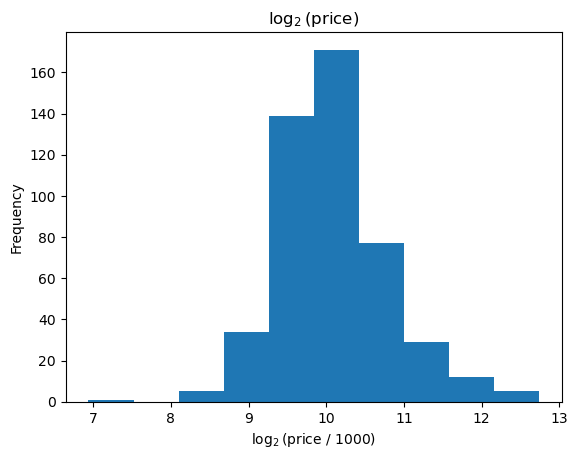

In [9]:
y_train.plot(kind="hist", title=r"$\log_2$(price)")
plt.xlabel(r"$\log_2$(price / 1000)");

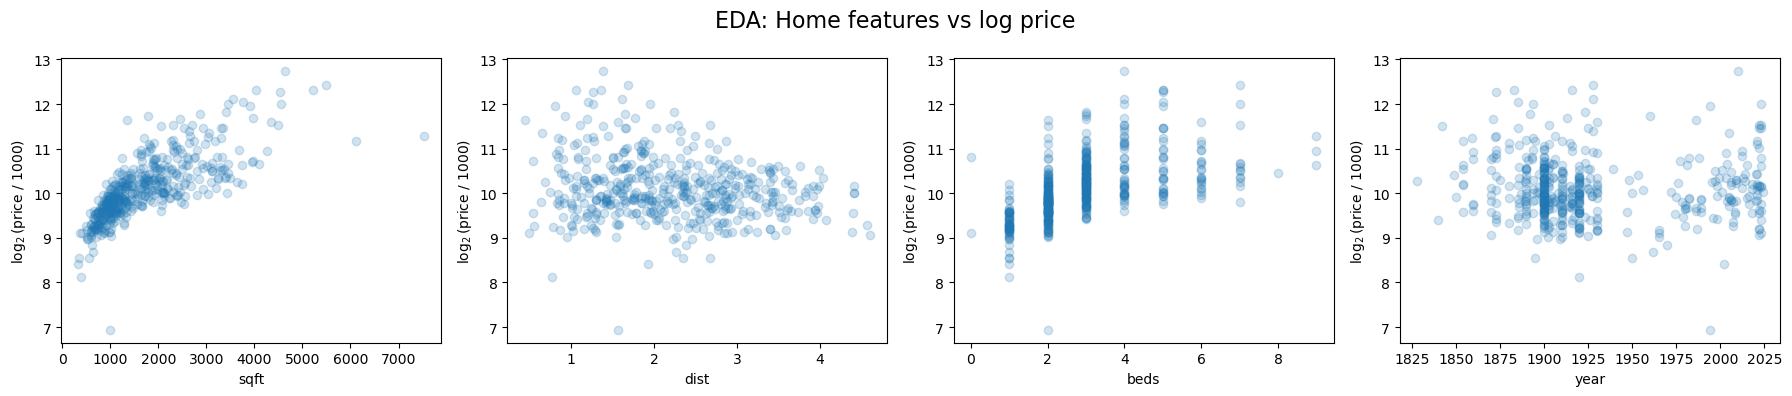

In [10]:
features_to_plot = ["sqft", "dist", "beds", "year"]

nrow = 1
ncol = len(features_to_plot)
fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(18, 4))

fig.suptitle("EDA: Home features vs log price", fontsize=16)

for ax, column in zip(axs.reshape(-1), features_to_plot):
    ax.scatter(X_train[column], y_train, alpha=0.2)
    ax.set_xlabel(column)
    ax.set_ylabel(r"$\log_2$(price / 1000)")

plt.tight_layout()

We see:

- **sqft** and **beds**: positive relationship with log price.  
- **dist** (distance from center): tends to have a negative relationship.  
- Some predictors are stronger than others.

Next, we'll fit a **decision tree regressor** and see how tree hyperparameters
(`max_depth`, `min_samples_leaf`, etc.) affect performance on this dataset.


### Decision Tree Regression + Hyperparameters

In [15]:
# Basic Tree Fit

tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_test)
mse_tree = mean_squared_error(y_test, y_pred_tree)
rmse_tree = np.sqrt(mse_tree)
rmse_tree

0.3920774913625021

In [16]:
# Effect of max_depth

depths = [2, 4, 6, 8, None]
results = []

for d in depths:
    model = DecisionTreeRegressor(max_depth=d, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    results.append((d, rmse))

results

[(2, 0.4467466776867115),
 (4, 0.36372264014575667),
 (6, 0.32262243357767395),
 (8, 0.354604988982734),
 (None, 0.3920774913625021)]

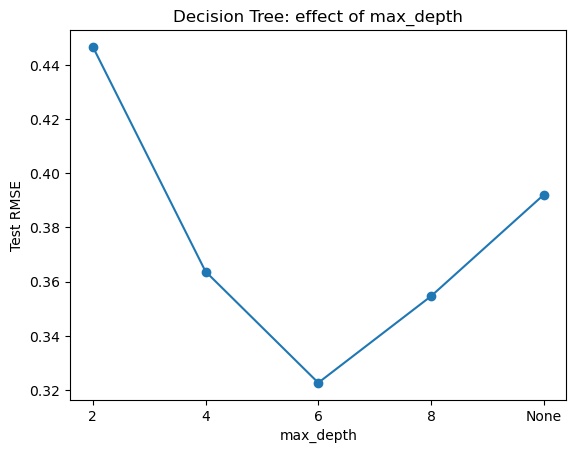

In [17]:
depth_vals = [str(d) for d, _ in results]
rmse_vals = [rmse for _, rmse in results]

plt.plot(depth_vals, rmse_vals, marker="o")
plt.xlabel("max_depth")
plt.ylabel("Test RMSE")
plt.title("Decision Tree: effect of max_depth");

### Interpreting the effect of `max_depth`

From the plot/numbers, we see:

- `max_depth = 2` $\rightarrow$ highest RMSE: the tree is **too simple** $\rightarrow$ underfits (**high bias**).
- Increasing depth to 4 and 6 **improves** test RMSE: the tree can capture more structure.
- Around `max_depth = 6` we get the **best** test RMSE (sweet spot for this dataset).
- Going deeper (8 or `None` = fully grown) makes test RMSE **worse again** $\rightarrow$ the tree starts to **overfit** (**high variance**).

This is the classic **bias–variance tradeoff** for decision trees:

- Shallow trees $\rightarrow$ high bias, low variance.  
- Very deep trees $\rightarrow$ low bias, high variance.  
- A moderate depth often gives the best generalization performance.

### From a single tree to an ensemble

We just saw that:

- Very **shallow** trees underfit (high bias).
- Very **deep** trees overfit (high variance).
- A medium `max_depth` can work well, but a single tree is still **unstable**:
  small changes in the training data can lead to a very different tree.

Another way to reduce **variance** is to keep using **high-variance trees**
(e.g., deep trees) but **average many of them**.

This idea is called **Bagging** (**B**ootstrap **Agg**regat**ing**).

### What Bagging does

1. **Bootstrap samples**  
   - From the original training set, draw $B$ new datasets of the **same size**,  
     each sampled **with replacement** (so some points repeat, some are left out).

2. **Fit one high-variance model per bootstrap sample**  
   - Here, we fit a **deep decision tree** on each bootstrap sample  
     $\rightarrow$ $\text{Tree}_1, \text{Tree}_2, \dots, \text{Tree}_B$.

3. **Aggregate their predictions**  
   - **Regression:** average the $B$ predictions.  
   - **Classification:** take a majority vote.

Because each tree sees a slightly different dataset, their errors are **less correlated**.  
Averaging them keeps the **low bias** of deep trees but **reduces variance**, giving more
stable, better generalizing predictions.


<img src="fig/bagging1.png" alt="bagging" width="60%"/>

### Bagging Implementation

In [18]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# High-variance base learner: deep tree
base_tree = DecisionTreeRegressor(
    max_depth=None,
    min_samples_leaf=1,
    random_state=109
)

bag = BaggingRegressor(
    estimator=base_tree,
    n_estimators=100,
    bootstrap=True,
    n_jobs=-1,
    random_state=109
)

bag.fit(X_train, y_train)
y_pred_bag = bag.predict(X_test)

mse_bag = mean_squared_error(y_test, y_pred_bag)
rmse_bag = np.sqrt(mse_bag)
rmse_bag


0.30847264163582205

#### How n_estimators behaves:

This helps us see that adding more trees $\neq$ overfitting

In [19]:
n_list = [1, 10, 50, 100, 200]
bag_results = []

for n in n_list:
    bag = BaggingRegressor(
        estimator=base_tree,
        n_estimators=n,
        bootstrap=True,
        n_jobs=-1,
        random_state=109
    )
    bag.fit(X_train, y_train)
    y_pred = bag.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    bag_results.append((n, rmse))

bag_results

[(1, 0.4040785335631112),
 (10, 0.3280338007374429),
 (50, 0.308778939967646),
 (100, 0.30847264163582205),
 (200, 0.3109338161748684)]

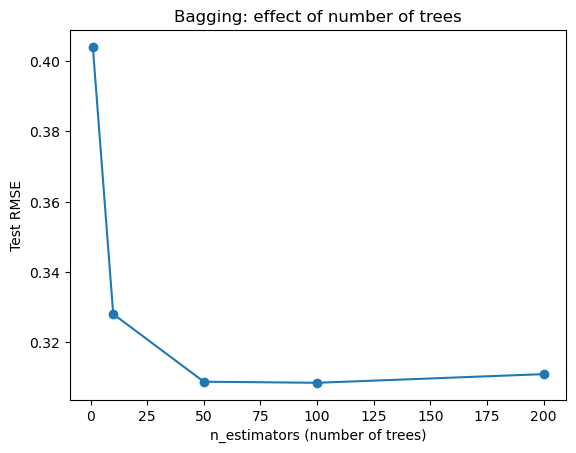

In [20]:
n_vals = [n for n, _ in bag_results]
rmse_vals = [rmse for _, rmse in bag_results]

plt.plot(n_vals, rmse_vals, marker="o")
plt.xlabel("n_estimators (number of trees)")
plt.ylabel("Test RMSE")
plt.title("Bagging: effect of number of trees");


#### Bagging hyperparameters (what changed vs a single tree?)

With Bagging we have:

- **Tree-level hyperparameters** (same as before):  
  `max_depth`, `min_samples_leaf`, `min_samples_split`  
  $\rightarrow$ control how **complex** each tree is (bias/variance of the base learner).

- **New ensemble hyperparameter**:  
  `n_estimators` = number of trees we average  
   $\rightarrow$ controls **variance** of the ensemble.

Key idea:

- A single deep tree is **low bias, high variance**.
- Bagging keeps the trees deep (low bias) but **averages many of them**, so
  variance drops.
- Increasing `n_estimators` does **not** cause overfitting; test error usually
  improves then **plateaus** as we add more trees.

### From Bagging to Random Forest

Bagging already:

- Trains many **bootstrapped trees**.
- Averages their predictions to **reduce variance**.

**Random Forest** adds one more source of randomness:

- At each split, a tree only looks at a **random subset of features** instead of all features.

This:
- Forces different trees to consider **different predictors**,
- Makes trees **less correlated** with each other,
- So averaging them can reduce variance **even more** than plain Bagging.


In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

rf = RandomForestRegressor(
    n_estimators=100,     # number of trees
    max_depth=None,       # let trees grow deep
    min_samples_leaf=1,
    max_features="sqrt",  # random subset of features at each split
    n_jobs=-1,
    random_state=109
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
rmse_rf

0.30853732865271705

#### Random Forest hyperparameters

Random Forest keeps all the **tree-level** and **ensemble-level** hyperparameters
we've already seen, plus one key new one.

- **Tree complexity (same as single tree / Bagging):**
  - `max_depth`, `min_samples_leaf`, `min_samples_split`
  - $\rightarrow$ control how **complex** each tree can be (bias/variance of base learner).

- **Ensemble size (same as Bagging):**
  - `n_estimators` = number of trees we average
  - $\rightarrow$ controls **variance** via averaging; more trees $\rightarrow$ more stable, until it plateaus.

- **New in Random Forest: feature subsampling**
  - `max_features` = how many predictors to consider at each split.
  - Smaller `max_features`:
    - trees see **different subsets** of features,
    - trees become **less correlated**,
    - averaging them gives better **variance reduction**.
  - `max_features` is **not** a stopping rule; it doesn't limit depth, just which
    features are allowed to compete at each split.

In short:

- Tree hyperparameters $\rightarrow$ control **complexity**.
- `n_estimators` $\rightarrow$ controls **variance** by averaging more trees.
- `max_features` $\rightarrow$ controls **correlation** between trees in a Random Forest.


## QUICK RECAP

### Final Comparison: Single Tree vs Bagging vs Random Forest

Let's summarize what we observed on the Cambridge housing data:

| Model                          | Bias            | Variance         | Key Hyperparameters                       | Typical Behavior                       | Test RMSE (ours) |
|--------------------------------|-----------------|------------------|--------------------------------------------|----------------------------------------|------------------|
| **Single Decision Tree**       | Low-Medium bias | **High variance** | `max_depth`, `min_samples_leaf`            | Unstable; small data changes $\rightarrow$ new tree | ~0.3228 |
| **Bagging (Trees)**            | **Low bias**    | Medium variance  | `n_estimators`                              | Averages many deep trees $\rightarrow$ variance drops | ~0.3084 |
| **Random Forest**              | Low-Medium bias | Low-Medium variance | `n_estimators`, `max_features`             | Further de-correlates trees $\rightarrow$ usually best generalization | ~0.3085 |

**Key takeaways**:

- A **single deep tree** overfits and is unstable (high variance).  
- **Bagging** keeps trees deep (low bias) but **averages them** to reduce variance.  
- **Random Forest** = Bagging + **feature subsampling** (`max_features`)  
  $\rightarrow$ reduces **correlation** between trees $\rightarrow$ often slightly better than Bagging.  
- In practice, **Random Forest and Bagging often perform similarly**, especially on small/medium datasets or when a few strong predictors dominate.


**A note on Random Forest vs Bagging**

In our results, **Random Forest and Bagging have almost identical test RMSE**.  
That's not a bug - it's an important point:

- Random Forest does **not** guarantee strictly better performance than Bagging on every dataset.
- Its extra randomness (`max_features`) can:
  - **Help** when features are correlated or when we really want to decorrelate trees.
  - **Hurt slightly** when a few features are very strong and we sometimes *hide* them from splits.
- With a reasonable choice of hyperparameters, Bagging and Random Forest often end up in the **same ballpark** in terms of test error.

So the way to think about it:

- Use **Bagging** when you just want to average many strong base trees.  
- Use **Random Forest** when you also want to **decorrelate** trees via feature subsampling - often helpful, but not magically better every time.


# APPENDIX

### Out-of-Bag Score (OOB)

*QUESTION:* 
- What is out-of-bag (OOB) error? 
- How can we take advantage if it to improve our model's performance?
- Why OOB is a great method?

<img src="fig/oob.png" alt="tree_adj" width="60%"/>

Out-of-bag (OOB) error/Out-of-bag estimate is validated method availble to us whenever we use a bagged ensemble.
OOB samples can be seen as the validation set, generated by bootstrap process. So, we don’t need to do the explicit setup another validation set. Compared to CV, it has the following advantages.

There is less computational cost for OOB error compared to traditional CV. 


In [15]:
n_trees = 1000  # This can be tuned
# Create a decision tree to serve as the base model in the bagged ensemble
best_params = best_tree.get_params()
# model = DecisionTreeRegressor().set_params(**best_params)
# model = DecisionTreeRegressor(max_leaf_nodes=int(2*best_params['max_leaf_nodes']))
model = DecisionTreeRegressor(max_depth=None)

# Initializing arrays to store results
predictions_train = np.zeros(shape=(X_train.shape[0], n_trees))
predictions_test = np.zeros(shape=(X_test.shape[0], n_trees))
predictions_oob = (
    np.zeros(shape=(X_train.shape[0], n_trees)) * pd.NA
)  # fill /w NA by default

# Conduct bootstraping iterations
for i in range(n_trees):
    boot_idx = np.random.choice(X_train.shape[0], size=X_train.shape[0], replace=True)
    boot_X = X_train.iloc[boot_idx]
    boot_y = y_train.iloc[boot_idx]

    model.fit(boot_X, boot_y)
    predictions_train[:, i] = model.predict(X_train)
    predictions_test[:, i] = model.predict(X_test)

    # Get OOB samples
    oob_mask = ~np.isin(np.arange(X_train.shape[0]), boot_idx)
    X_oob = X_train[oob_mask]
    y_oob = y_train[oob_mask]
    oob_p = model.predict(X_oob)
    predictions_oob[oob_mask, i] = oob_p  # Update prediction results of this tree

# Make Predictions Dataframe
columns = ["Bootstrap-Model_" + str(i + 1) for i in range(n_trees)]
predictions_train = pd.DataFrame(predictions_train, columns=columns)
predictions_oob = pd.DataFrame(predictions_oob, columns=columns)
predictions_test = pd.DataFrame(predictions_test, columns=columns)

In [16]:
bag_train_r2 = r2_score(y_train, predictions_train.mean(axis=1))
bag_test_r2 = r2_score(y_test, predictions_test.mean(axis=1))
bag_oob_r2 = r2_score(y_train, predictions_oob.mean(axis=1))
print(f"Train R^2:\t{bag_train_r2:.4f}")
print(f"OOB R^2:\t{bag_oob_r2:.4f}")
print(f"Test R^2:\t{bag_test_r2:.4f}")

Train R^2:	0.9714
OOB R^2:	0.7880
Test R^2:	0.8059


### SKLearn's BaggingRegressor

From SKlearn's [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html):

"A Bagging regressor is an ensemble meta-estimator that fits base regressors each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it."

The most important arguments are `estimator` which defines the base estimators from which the bagged ensemble is composed and well as `n_estimators`, the number of estimators in the ensemble.
If you want access to the `oob_score_` attribute on the fitted BaggingRegressor you will also need to set `oob_score=True` since it is `False` by default to save a bit of computation.

The individual estimators in the ensemble can be accessed by the `estimators_` attribute.

`warm_start=True` will cause the BaggingRegressor to re-use the previous estimators when re-fitting with a larger setting of `n_estimators`. This saves computation as you only need to fit the new trees being added to the ensemble.

In [17]:
# Define a BaggingRegressor using a DecisionTreeRegressor as its base estimator
bag = BaggingRegressor(
    estimator=DecisionTreeRegressor(), n_estimators=100, oob_score=True
)

In [18]:
# Fit on train
bag.fit(X_train, y_train)

BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=100,
                 oob_score=True)

In [19]:
# Inspect OOB accuracy
print("OOB ACC:", bag.oob_score_)

OOB ACC: 0.7860083912281837


In [20]:
# Inspect OOB accuracy
print("OOB ACC:", bag.oob_score_)

OOB ACC: 0.7860083912281837


In [21]:
# Inspect test accuracy
print("Test ACC:", bag.score(X_test, y_test))

Test ACC: 0.8004255858922316


<div class="alert alert-success">
    <strong>🏋🏻‍♂️ ACTIVITY:</strong> Number of Estimator's Affect on BaggingRegressor </div>  

- Create a visualization showing how the number of estimators effects the bagging regressor's train and OOB scores.
- You should use the default, 'full-depth' trees as your base estimators.
- There are many ways to accomplish this!

**Hint:** You may want to adjust the y-axis limits of your plot. Why is this necessary?

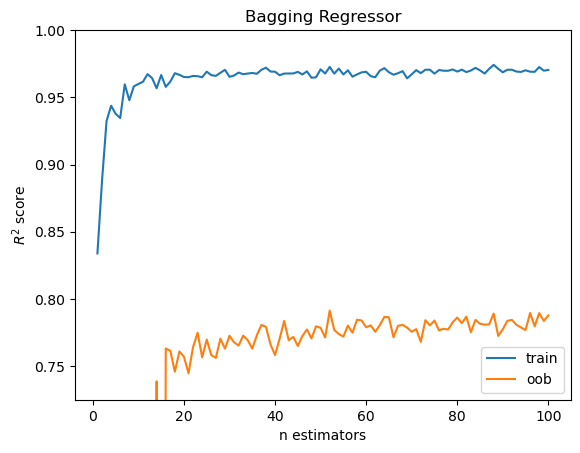

In [22]:
# your code here
bag = BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=None), oob_score=True)
max_estimators = 100
train_scores = np.zeros(max_estimators)
oob_scores = np.zeros_like(train_scores)
for i, n in enumerate(range(1, max_estimators + 1)):
    bag.n_estimators = n
    bag.fit(X_train, y_train)
    train_scores[i] = bag.score(X_train, y_train)
    oob_scores[i] = bag.oob_score_

plt.plot(range(1, max_estimators + 1), train_scores, label="train")
plt.plot(range(1, max_estimators + 1), oob_scores, label="oob")
plt.title("Bagging Regressor")
plt.xlabel("n estimators")
plt.ylabel("$R^2$ score")
plt.ylim(0.725, 1)
plt.legend()

**Q**: 🤔 Can you think of a way to further reduce the variance of the ensemble model?

### Weaknesses of Bagging

Bagging is a *greedy* algorithm. What does this mean?\
We always choose to split on the feature with the most impact: i.e., the most information gain.

$\bullet$ Because of their greedy nature, bagging ensembles are very likely to be correlated, especially in the shallower nodes of the individual decision trees.

### Why are decision trees greedy?

$\bullet$ Finding the optimal decision trees is an NP-complete problem, so in practice this is infeasible.

$\bullet$ Thus decision trees are **hueristic algorithms**. Hueristic algorithms are designed to solve problems by sacrificing optimality, accuracy, or precision in favor of speed. Hueristic algorithms are often used to solve NP-complete problems.

---

## Random Forest

Random Forest is a modified form of bagging that creates ensembles of independent decision trees. 
To *de-correlate the trees*, we: 
1. train each tree on a new bootstrapped sample of the full training set (same as in bagging) 
2. for each tree, at each split, we **randomly select a set of 𝐽′ predictors from the full set of predictors.** (not done in bagging)
3. From among the 𝐽′  predictors, we select the optimal predictor and the optimal corresponding threshold for the split. 

<font color='red'> *Question:* </font>  Why would this second step help (only considering random sub-group of features)?



The averaging in Random Forest is able to reduce even more variance because the resulting trees are less correlated.\
This reduces overfitting as seen in the smaller gap between the train and OOB scores.

Fit a RandomForestRegressor using the same `max_depth` and `n_estimators` as your final, large bagging model. But here we will set the `max_features` parameter to 'sqrt' to only consider a random set of predictors of size $\sqrt{J}$ at each split, where $J$ is the original number of predictors.

<font color='red'> NOTE: </font>  Please referring to the SKlearn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [23]:
rf = RandomForestRegressor(
    max_depth=None,
    n_estimators=1000,
    max_features="sqrt",
    oob_score=True,
    random_state=109,
)
rf.fit(X_train, y_train)
print(f"The train score is: {rf.score(X_train, y_train):.4f}")
print(f"The test score is: {rf.score(X_test, y_test):.4f}")
print(f"The OOB score is: {rf.oob_score_:.4f}")

The train score is: 0.9715
The test score is: 0.8181
The OOB score is: 0.7942


### Tuning a Random Forest

**Which parameters need to be tuned for a random forest model?**. Hint: there are 2 (or maybe 3)


Use Cross-Validation (via `GridSearchCV`) or out-of-bag error (similar to the bagged model above) to tune a random forest model.  Consider 'min_samples_split' in the set of [2,5,10,20] and 'max_features' in the set of [2,5,8].

<font color='red'> NOTE: </font> The choices of parameters under param_grid is based on the attributes in your estimator. For example, if your estimator is RandomForestRegressor, the choices of parameters are the attributes of the RandomForestRegressor, and you should refer to the SKlearn RandomForestRegressor documentation: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [24]:
rf2 = GridSearchCV(
    estimator=RandomForestRegressor(random_state=109),
    param_grid={"min_samples_split": [2, 5, 10, 20], "max_features": [2, 5, 8]},
    cv=5,
)
rf2.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=109),
             param_grid={'max_features': [2, 5, 8],
                         'min_samples_split': [2, 5, 10, 20]})

In [25]:
# Just refitting outside of GridSearchCV so that we can extract Variable Importances later
rf_tuned = RandomForestRegressor(
    max_features=rf2.best_params_["max_features"],
    min_samples_split=rf2.best_params_["min_samples_split"],
    random_state=109,
).fit(X_train, y_train)

In [26]:
rf2.best_params_

{'max_features': 5, 'min_samples_split': 2}

## 🌲 Bagging & Random Forest: Key Hyperparameters (A Simple Overview)



### **1. Number of Estimators (`n_estimators`) — Bagging & Random Forest**
- The number of trees in the ensemble.  
- **More trees → lower variance** and more stability.  
- Does **not overfit** as you increase it (test error plateaus).  
- Main control for ensemble size.

---

### **2. max_features — Random Forest Only**
- Number of features considered **at each split**.  
- **Smaller max_features → trees more different → lower correlation → better variance reduction.**  
- Key ingredient that differentiates Random Forest from pure Bagging.

---

### **3. Stopping Conditions (Tree Complexity Controls)**
- Examples: `max_depth`, `min_samples_split`, `min_samples_leaf`.  
- These **control how large/deep each individual tree can grow**.  
- Affect the **bias–variance tradeoff** of each tree, not the forest size.

---

### **In a Nutshell**
- **Tree complexity**: controlled by `max_depth`, `min_samples_split`, etc.  
- **Ensemble size**: controlled by `n_estimators` (more trees → lower variance).  
- **Tree correlation**: controlled by `max_features` (RF only).



## Optional: QA to ponder

**Q**: 🤔 A bagging model is just a special case of a random forest model.  Discuss.

**Q**: 🤔 **Why** do random forests improve predictions over a bagging model?  Under what conditions (think relationships among all of your variables) will this improvement be large?  When will it be small or perform even worse?

**Q**: 🤔 A bagging model is just a special case of a random forest model.  Discuss.

**Q**: 🤔 **Why** do random forests improve predictions over a bagging model?  Under what conditions (think relationships among all of your variables) will this improvement be large?  When will it be small or perform even worse?

---

## Optional:  Model Interpretability 🔎



- As a data scientist, you need to know ins and outs of machine learning models.
- Often you need to provide a **trustworthy, transparent, and accountable explanation** to stakeholders beyond the final evaluation metrics (e.g., $R^2$, MSE, Accuracy, ROC-AUC score, etc.).
- To provide a good justification, we would do well to have an easily generalizable framework to explain a machine learning model.

But there are inherent trade-off between model interpretability and accuracy.\
And there are many ways to explain the machine learning models:
- Use only interpretable models
    - Linear regression, logistic regression, decision trees, etc.
    - But these are often times too simple and don't perform well!
- Use model specific interpretation methods
    - Lacks generalization because it is model dependent!
- Use **model-agnostic methods**

#### Fitting 5 tree-based models to predict `log2(price)` from `sqft` alone

The simplest (and best?) way to interpret a machine learning model is through the plotting the predictions! For a regression-type problem, that means visualizing $\hat{y}$ vs. $x_j$.  For a calssification problem, that means visualizing $\hat{P}(y=1)$ vs. $x_j$ or visualizing the decision boundary vs. $x_j$ and $x_{j`}$.

When there is just a single predictor in the model, then plotting the predictions is easy (see below)!  

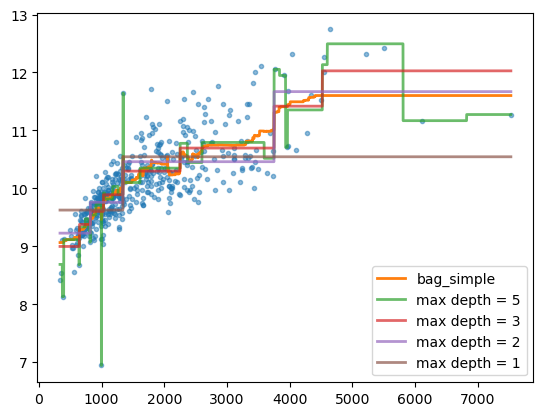

In [27]:
# Range of observed sqft predictor
dummy_x = np.arange(np.min(homes["sqft"]), np.max(homes["sqft"]), 1)

plt.plot(X_train["sqft"], y_train, ".", alpha=0.5)

bag_simple = RandomForestRegressor(
    min_samples_split=50,
    n_estimators=500,
    max_features=1,
    oob_score=True,
    random_state=109,
)
bag_simple.fit(X_train[["sqft"]], y_train)

plt.plot(
    dummy_x,
    bag_simple.predict(dummy_x.reshape(-1, 1)),
    label="bag_simple",
    alpha=1,
    lw=2,
)

for i in [5, 3, 2, 1]:
    dtree = tree.DecisionTreeRegressor(max_depth=i)
    dtree.fit(X_train[["sqft"]], y_train)
    plt.plot(
        dummy_x,
        dtree.predict(dummy_x.reshape(-1, 1)),
        label=("max depth = " + str(i)),
        alpha=0.7,
        lw=2,
    )

plt.legend()

**Q**: 🤔 Which of these models are overfit?  Which are potential underfit?  What do the models say about the relationship between `log2(price)` and `sqft`?  Why isn't there technically a random forest model?

#### Fitting Four multiple-predictor ML Models

When there are multiple predictors, things get tough! We fit 4 different tree-based models using the 10 predictor $X$ from before:

Start with 2 decision tree to add to our previous ensemble models: the tuned random forest model (`rf2`) and the untuned bagged model (`bag`)

In [28]:
# fit a possibly underfit (depth = 3) decision tree regressor
dt3 = tree.DecisionTreeRegressor(max_depth=3)
dt3.fit(X_train, y_train)

# fit a well-tuned decision tree regressor using our best params from before
dt_tuned = tree.DecisionTreeRegressor(max_leaf_nodes=best_params["max_leaf_nodes"])
dt_tuned.fit(X_train, y_train)

# and the other two models are your well-tuned Random Forest (`rf2`) and your untuned `bag` model

DecisionTreeRegressor(max_leaf_nodes=20)

We now explore the relationships by plotting the predictions (we'll stick with sqft for now).  

**Q**: 🤔 How can we generate these prediction plots?  What's the tricky detail we need to worry about?

**Q**: 🤔 How do tree-based models handle interactions?  Why does this make sense?

In [29]:
# Create the data frame of means to do the prediction
means1 = X_train.mean(axis=0)
means_df = (means1.to_frame()).transpose()

# Do the prediction across range of observed sqft
dummy_x = np.arange(np.min(homes["sqft"]), np.max(homes["sqft"]), 1)
means_df = pd.concat([means_df] * dummy_x.size, ignore_index=True)
means_df["sqft"] = dummy_x
yhat_rf = rf2.predict(means_df)

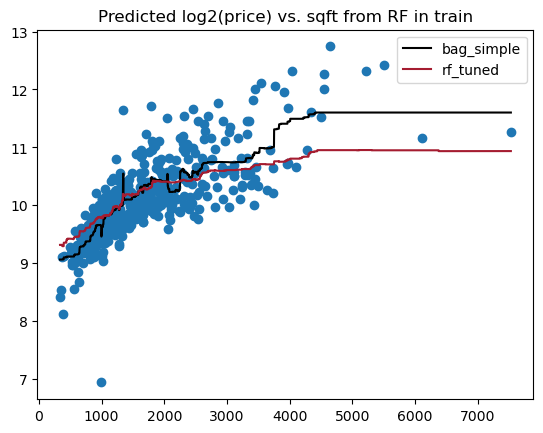

In [30]:
# plots yhat vs. sqft at means of the other predictors
plt.scatter(X_train["sqft"], y_train)
plt.plot(
    dummy_x,
    bag_simple.predict(dummy_x.reshape(-1, 1)),
    label="bag_simple",
    color="#000000",
)
plt.plot(means_df["sqft"], yhat_rf, label="rf_tuned", color="#A51C30")
plt.title("Predicted log2(price) vs. sqft from RF in train")
plt.legend()

*Note: Harvard Colors: https://seas.harvard.edu/office-communications/brand-style-guide/color-palette

**Q**: 🤔 Describe what you see.  How does the RF model `log2(price)`s relationship with `sqft`? How is this different from the *simple* RF/bagging model?  Why is this not surprising?

**$^*$Hint**: Think simple vs. multiple regression.

In [31]:
# Create the data frame of means for condos and separately
# for multi-family homes to do the prediction
means_condo = X_train[
    (X_train["multifamily"] + X_train["singlefamily"] + X_train["townhouse"]) == 0
].mean(axis=0)
condo_df = (means_condo.to_frame()).transpose()
condo_df = pd.concat([condo_df] * dummy_x.size, ignore_index=True)
condo_df["sqft"] = dummy_x

means_multi = X_train[X_train["multifamily"] == 1].mean(axis=0)
multi_df = (means_multi.to_frame()).transpose()
multi_df = pd.concat([multi_df] * dummy_x.size, ignore_index=True)
multi_df["sqft"] = dummy_x


# Do the prediction at all observed sqft for each home type
yhat_rf_condo = rf2.predict(condo_df)
yhat_rf_multi = rf2.predict(multi_df)

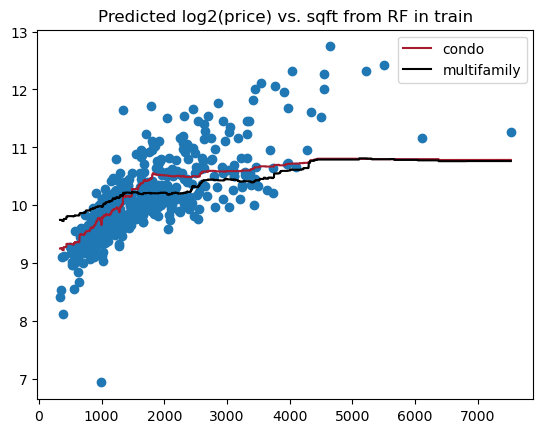

In [32]:
# plots yhat vs. sqft at means of the other predictors for condos vs. multifamily homes
plt.scatter(X_train["sqft"], y_train)
plt.plot(condo_df["sqft"], yhat_rf_condo, label="condo", color="#A51C30")
plt.plot(multi_df["sqft"], yhat_rf_multi, label="multifamily", color="#000000")
plt.title("Predicted log2(price) vs. sqft from RF in train")
plt.legend()

**Q**: 🤔 Describe what you see.  How does the RF model `log2(price)`s relatoinship with `sqft`?  What does this say about any interaction effects involving `sqft`?

### Feature Importance (MDI)

Fill in the blanks below to calculate the variable importances from the 4 untuned models above.

In [33]:
X.columns[np.flip(np.argsort(dt3.feature_importances_))]

Index(['sqft', 'baths', 'dist', 'lotsize', 'hoa', 'year', 'beds', 'townhouse',
       'singlefamily', 'multifamily'],
      dtype='object')

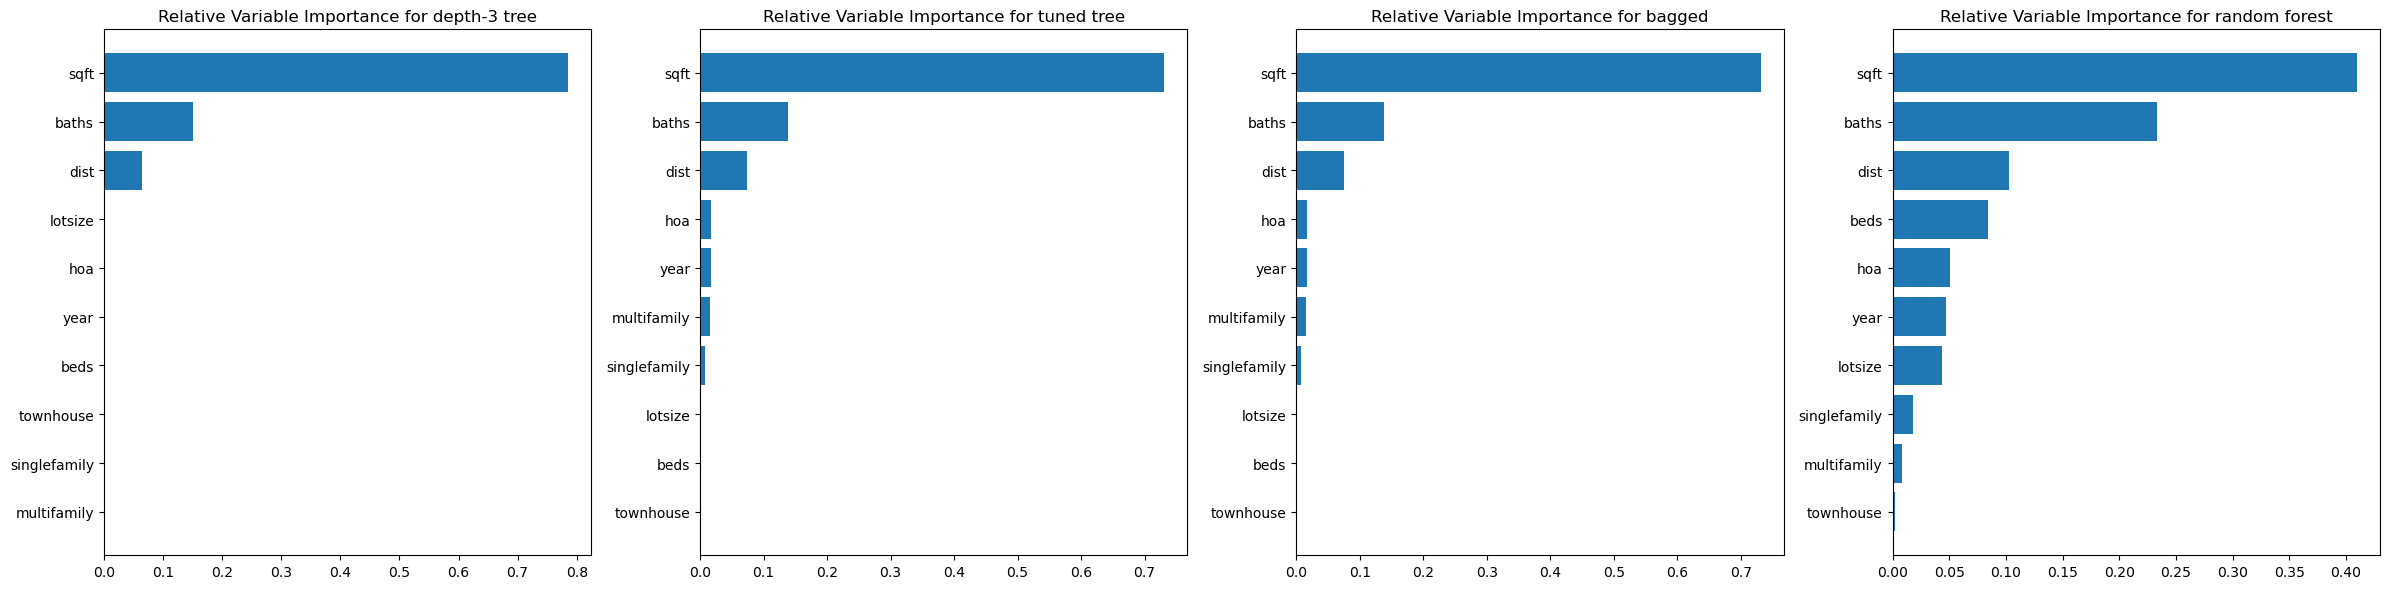

In [34]:
fig, axs = plt.subplots(1, 4, figsize=(24, 6))
models = {
    "depth-3 tree": dt3,
    "tuned tree": dt_tuned,
    "bagged": bag,
    "random forest": rf_tuned,
}

num_features = 10
for i, (name, model) in enumerate(models.items()):
    # calculation is more manual for the bagged model
    if name == "bagged":
        imporances = np.array([t.feature_importances_ for t in model.estimators_]).mean(
            axis=0
        )
    else:
        importances = model.feature_importances_
    order = np.argsort(importances)[-num_features:]
    axs[i].barh(
        range(num_features), importances[order], tick_label=X_train.columns[order]
    )
    axs[i].set_title(f"Relative Variable Importance for {name}")

plt.tight_layout()

**Q**: 🤔 How do these variable importance measures compare for these 4 models?  Which predictor is most important in general?  How is it related to `price`? 

**What other approaches can be taken to measure variable importance?**

One alternative for random forest:
- Record the prediction accuracy on the *oob* samples for each tree.
- Randomly permute the data for column $j$ in the *oob* samples, then record the accuracy again.
- The decrease in accuracy as a result of this permuting is averaged over all trees, and is used as a measure of the importance of variable $j$ in the random forest. 

This idea of re-permuting a variable and *refitting* a model to see how much more
poorly it performs is called **permutation feature importance**.

---

### Permutation Importance

Keep in mind that when two features are correlated and one of the features is permuted, the model will still have access to the feature through its correlated feature.

**Q:** 🤔 What is the one glaring disadvantage to the permutation approach? ⏲️

**Q:** 🤔 This method is often preferred to the standard, MDI feature importance approach shown above, why?

SKLearn provides a built-in implementation of permutation importance that we can use to evaluate our model:

In [35]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance
pi_results = permutation_importance(rf, X_test, y_test, n_repeats=50, random_state=42)

# Create a DataFrame to display results
pi_data = {
    "importance_mean": pi_results["importances_mean"],
    "importance_std": pi_results["importances_std"],
    "feature": X_test.columns,
}
pi_df = pd.DataFrame(pi_data).sort_values("importance_mean", ascending=False)

# Sort by importance for plotting
pi_df_sorted = pi_df.sort_values("importance_mean", ascending=True).reset_index(
    drop=True
)
pi_df_sorted

,importance_mean,importance_std,feature
0,0.004863,0.004049,multifamily
1,0.004958,0.001390,townhouse
2,0.010702,0.005894,singlefamily
3,0.023983,0.005075,year
4,0.025367,0.005733,hoa
5,0.025940,0.006226,lotsize
6,0.038419,0.009244,beds
7,0.111398,0.019765,dist
8,0.152364,0.024828,baths
9,0.431882,0.045966,sqft


The results show:
- importance_mean: Average decrease in model score when the feature is permuted
- importance_std: Standard deviation of the importance across permutations
- feature: Name of the feature being evaluated

Higher importance values indicate features that, when randomly shuffled, lead to larger decreases in model performance.

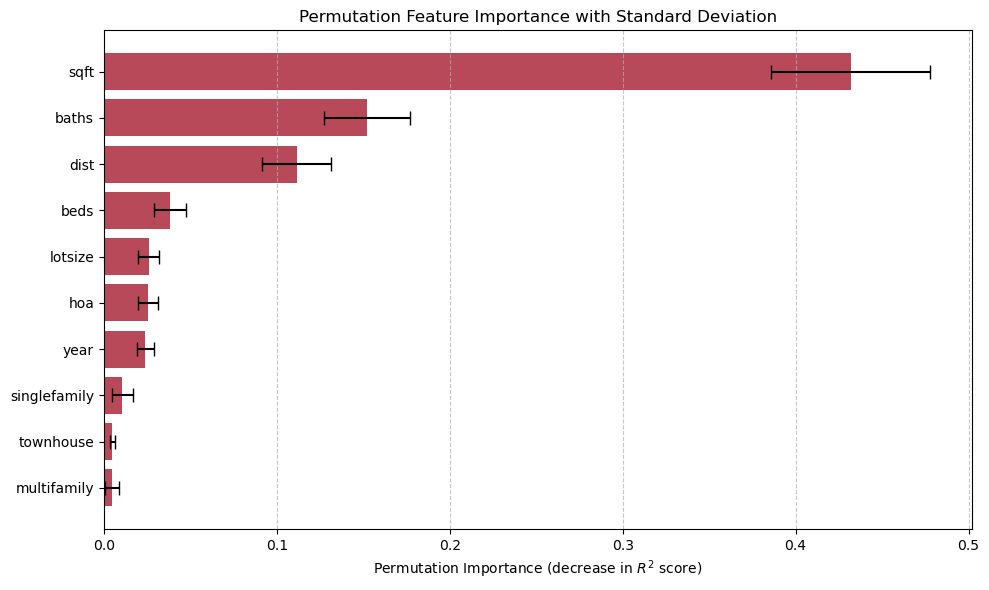

In [36]:
# Feature importance barplot with error bars
plt.figure(figsize=(10, 6))
plt.barh(
    range(len(pi_df_sorted)),
    pi_df_sorted["importance_mean"],
    xerr=pi_df_sorted["importance_std"],
    capsize=5,
    alpha=0.8,
    color="#A51C30",
)  # Harvard Crimson color!
plt.yticks(range(len(pi_df_sorted)), pi_df_sorted["feature"])
plt.xlabel("Permutation Importance (decrease in $R^2$ score)")
plt.title("Permutation Feature Importance with Standard Deviation")

# Add grid for easier comparison
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()

**Q**: 🤔 How do the permutation importance measures compare to the default variable importance in the random forest?  

---

Variable Importance is great! It tells you what features are important in shaping the model predictions.\
But what is missing?
- It does not give any measure for *how* the predictors are related to the response (positive, negative, quasi-linear, curved, interactions, etc.).
- This is where the parametric model wins out! Inference and interpretations are much easier and is the whole point of such models.

**Q:** 🤔 What can we do to measure these relationships in a machine learning or nonparametric model? What did we do with k-NN? 

Well, we could just plot the predictions! Easy with 1 predictor, but what if we have hundreds?

How do I extract the relationship between a given predictor and the response when, in the model, it is embedded in the context of the other predictors?\
We could hold all the other variables constant!

What needs to be done algorithmically to put this in practice?
Set the other predictors equal to *something* and only vary the predictor of interest)

---

### LIME 

The above stratagies attempt to give us a **global** explanation of our model's predictions.
But we may be interested in a **local** explanation. That is, why did our blackbox model give *a particular* observation the prediction it did?

A method called **LIME** was proposed in the paper ["Why Should I Trust You?": Explaining the Predictions of Any Classifier](https://arxiv.org/pdf/1602.04938v3.pdf), and it attempts to do just this. So what is LIME?

**Locally**: The explanation should be able to explain how the model behaves for individual observations.\
**Interpretable:** The explanation must be easy to understand by humans (but may depend on the target audience).\
**Model-agnostic:** The method should be able to explain any model.\
**Explanations:** self-explanatory 😁. This is the whole goal!

The approach is to use a directly interpretable model (e.g., a linear model) to help explain a model that is not directly interpretable.

**LIME ALGORITHM**
1. Select your observation of interest for which you want to have an explanation of its black box prediction.
2. Randomly generate points all over the feature space (sample X values from a Normal distribution inferred from the training set)
3. Get the black box predictions for these new points.
4. Weight each of the generated points based on their proximity to the point of interest using a kenerl function (e.g., exponential, Gaussian, etc.)
5. Fit a *weighted*, interpretable model on the synthetic data and the original model's predictions.
6. Explain the prediction by interpreting the local model.

This method can be applied to tabular data, text, and images!

**Toy Example: Classification Problem**

<img src='fig/LIME_plot.png' width='400px'>

In the plot above, the colored regions represent either side of the original model's decision boundary.\
The large red marker is our point of interest.\
The other points are the generated data. Their color represents the *original* model's predictions and their size represents their weight based on their distance from the point of interest.\
The dashed line is the predictions of the interpretable surrogate model.

The **objective** can be expressed as:

<img src='fig/LIME_eq.png'>

The explanation model for observation $x$ is the model $g$ (e.g., logistic regression model) that minimizes loss $L$ (e.g., cross-entropy), which measures how close the explanation is to the prediction of the original model $f$ (e.g., random forest), while the model complexity $\Omega$ is kept low (e.g., prefer fewer features).\
$G$ is the family of possible explanations.\
$\pi_x$ is a proximity measure defining a neighborhood around instance $x$ we consider for an explanation.

There are several LIME implementations for Python. We'll be using one simply called [lime](https://github.com/marcotcr/lime).

Because we're working with tabular data we'll be using [LimeTabularExplainer](http://gael-varoquaux.info/interpreting_ml_tuto/content/02_why/04_black_box_interpretation.html).

In [37]:
# !pip install lime

In [38]:
import lime

In [39]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(
    X_train.values, feature_names=X_train.columns, class_names=[0, 1], mode="regression"
)

In [40]:
idx = 109

exp = explainer.explain_instance(X_train.values[idx], rf.predict, num_features=10)

print("Observation #: %d" % idx)
print("Predicted Price (in thousands) =", 2 ** (rf.predict(X_train)[idx]))
print("Actual Price (in thousands): %s" % 2 ** (y_train.iloc[idx]))

Observation #: 109
Predicted Price (in thousands) = 1267.6566166672658
Actual Price (in thousands): 1304.9999999999998


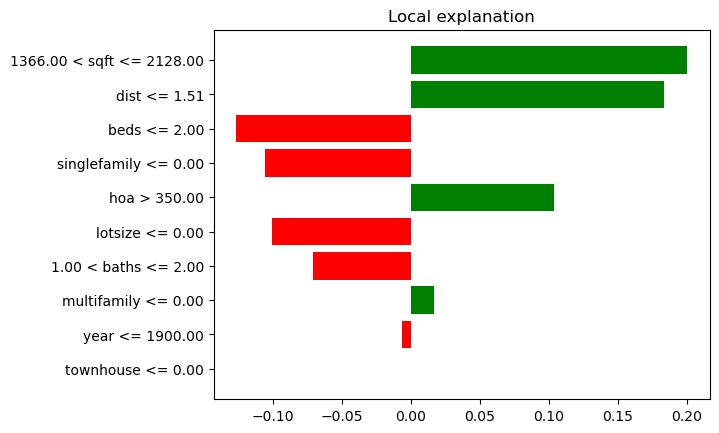

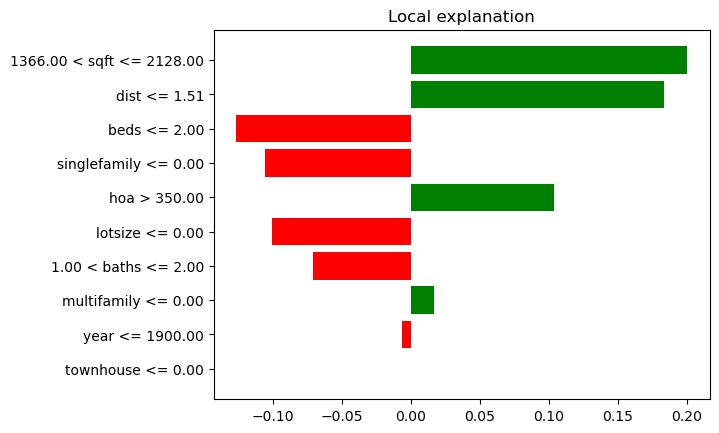

In [41]:
### Plot the results
exp.as_pyplot_figure()

In [42]:
# change the observation number and see what changes.
idx = 209

exp = explainer.explain_instance(X_train.values[idx], rf.predict, num_features=10)

print("Observation #: %d" % idx)
print("Predicted Price (in thousands) =", 2 ** (rf.predict(X_train)[idx]))
print("Actual Price (in thousands): %s" % 2 ** (y_train.iloc[idx]))

Observation #: 209
Predicted Price (in thousands) = 691.8722565609235
Actual Price (in thousands): 628.9999999999997


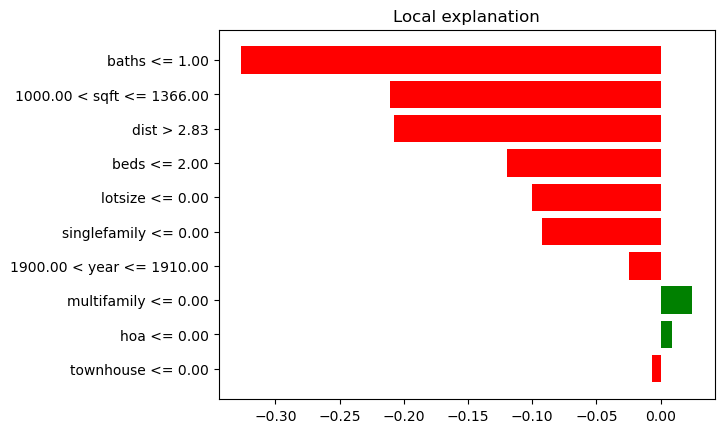

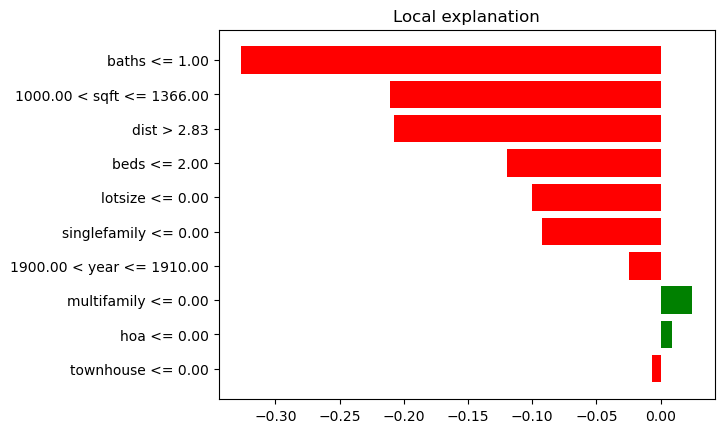

In [43]:
### Plot the results
# exp.as_list()
exp.as_pyplot_figure()

We also have a `show_in_notebook` methode but the pyplot figure one above is more concise.

In [44]:
exp.show_in_notebook(show_table=True, show_all=False)

You can also print the explanation as list.

In [45]:
exp.as_list()

[('baths <= 1.00', -0.32672902187440495),
 ('1000.00 < sqft <= 1366.00', -0.21084069650968457),
 ('dist > 2.83', -0.20787267490668396),
 ('beds <= 2.00', -0.11950853746043653),
 ('lotsize <= 0.00', -0.10034620178235608),
 ('singlefamily <= 0.00', -0.0927163060308104),
 ('1900.00 < year <= 1910.00', -0.024925202376773897),
 ('multifamily <= 0.00', 0.024479052392424944),
 ('hoa <= 0.00', 0.008861559396902476),
 ('townhouse <= 0.00', -0.006712034811639932)]

**Q:** 🤔 Interpret the LIME results above.  Do they agree with the other interpretations for the random forest model seen so far?

<div class="alert alert-success">
    <strong>🏋🏻‍♂️ TEAM ACTIVITY:</strong> Inspect the Worst Prediction</div>  

**Instruction:**
- Which observation in the test data does the random forest get *most wrong*?
    - Think about how you would determin this
- Use LIME to interpret this bad prediction.
    - Do we have any insight into what is driving the mistake or not?

In [46]:
# your code here
y_test.iloc[6]

8.884170519108435

Observation #: 14
Predicted Price (in thousands) = 923.0454391692358
Actual Price (in thousands): 900.0000000000002


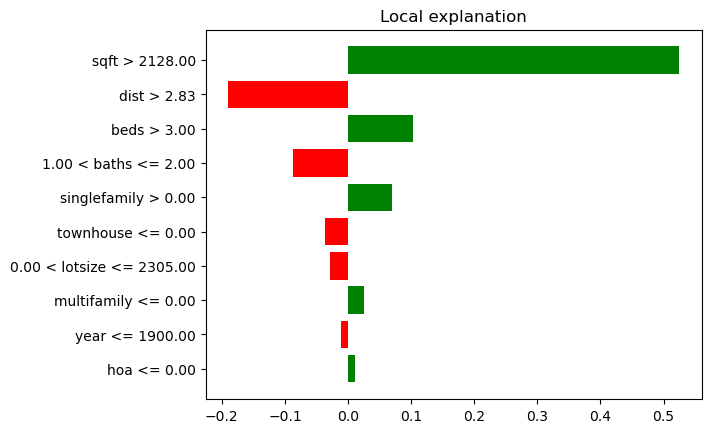

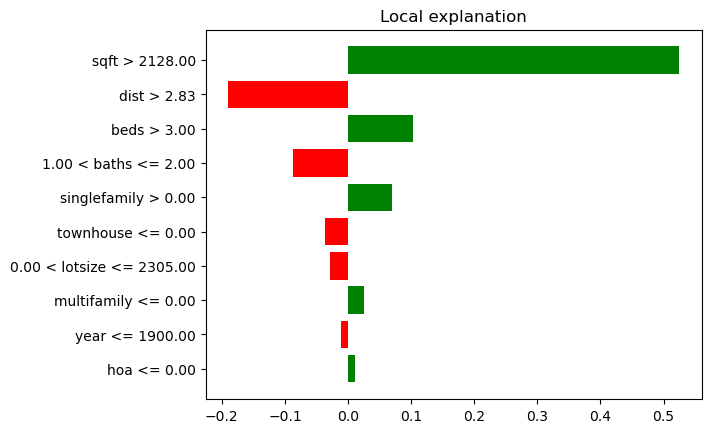

In [48]:
y_test_pred = rf.predict(X_test)
bad_idx = np.argmax(np.abs(y_test - y_test_pred))

exp = explainer.explain_instance(X_test.values[bad_idx], rf.predict, num_features=10)

print("Observation #: %d" % bad_idx)
print("Predicted Price (in thousands) =", 2 ** (rf.predict(X_train)[bad_idx]))
print("Actual Price (in thousands): %s" % 2 ** (y_train.iloc[bad_idx]))

exp.as_pyplot_figure()

#### Potential Issues

- The surrogate is fit to **randomly generated data**. And so interpretations can be *unstable*, changing with each run.
- The local approximation is highly sensitive to the choice of **kernel width**.

When LIME was initially proposed, the kernel used to define the neighborhood near the point of interest was selected using heuristics.\

<img src='fig/SHAP_kernel.png' width='700px'>

<p style="font-size:11px">Image by <a href="https://towardsdatascience.com/lime-explain-machine-learning-predictions-af8f18189bfe">Giorgio Visani</a></p>

Though there has been recent work on LIME's instability and sensitivity to kernel width. [OptiLIME](https://arxiv.org/pdf/2006.05714.pdf) proposes a more principled way.\
They have an open-source implementation on [Github](https://github.com/giorgiovisani/lime_stability/tree/master/OptiLIME).

#### Conclusion

We looked at how we can use prediciton plots, variable importance, permutation importance, and LIME to explain machine learning models in model-agnostic way.

But there will always remain a tension between explainability/interpretability and accuracy of statistical and machine learning models.


#### References

Interpretable ML: https://christophm.github.io/interpretable-ml-book

ELI5: https://eli5.readthedocs.io/en/latest/index.html

LIME: https://github.com/marcotcr/lime


🌈 **The End**